# Libraries

In [1]:
# !pip install --upgrade tensorflow
import random
import os
import io
import glob
import zipfile
import shutil

import scipy.misc
import sklearn.metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.__version__

'2.16.1'

# Dataset

In [3]:
# ds_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
# Change to this if running locally
ds_path = "../images/chest_xray"

In [4]:
test_path = ds_path + '/test'
train_path = ds_path + '/train'
val_path = ds_path + '/val'

test_normal_path = test_path + '/NORMAL'
test_pneumo_path = test_path + '/PNEUMONIA'

train_normal_path = train_path + '/NORMAL'
train_pneumo_path = train_path + '/PNEUMONIA'

val_normal_path = val_path + '/NORMAL'
val_pneumo_path = val_path + '/PNEUMONIA'

In [5]:
test_normal_list = os.listdir(test_normal_path)
test_pneumo_list = os.listdir(test_pneumo_path)

train_normal_list = os.listdir(train_normal_path)
train_pneumo_list = os.listdir(train_pneumo_path)

val_normal_list = os.listdir(val_normal_path)
val_pneumo_list = os.listdir(val_pneumo_path)



In [6]:
# ds_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

test_path = 'test'
train_path = 'train'
val_path = 'val'

normal_path = 'NORMAL'
pneumonia_path = 'PNEUMONIA'

set_list = [test_path, train_path, val_path]
label_list = [normal_path, pneumonia_path]

set_list, label_list

(['test', 'train', 'val'], ['NORMAL', 'PNEUMONIA'])

In [7]:
f"{ds_path}/{test_path}/{normal_path}"

'../images/chest_xray/test/NORMAL'

In [8]:
img_dict = {}

for s in set_list:
    for l in label_list:
        img_list = os.listdir(f"{ds_path}/{s}/{l}")
        for img in img_list:
            img_dict[f"{ds_path}/{s}/{l}/{img}"] = [img, s, l]

In [9]:
df = pd.DataFrame(data = img_dict).T.reset_index()
df.columns = ['path', 'filename', 'set', 'label']
df[['set', 'label']].value_counts()

set    label    
train  PNEUMONIA    3875
       NORMAL       1341
test   PNEUMONIA     390
       NORMAL        234
val    NORMAL          8
       PNEUMONIA       8
Name: count, dtype: int64

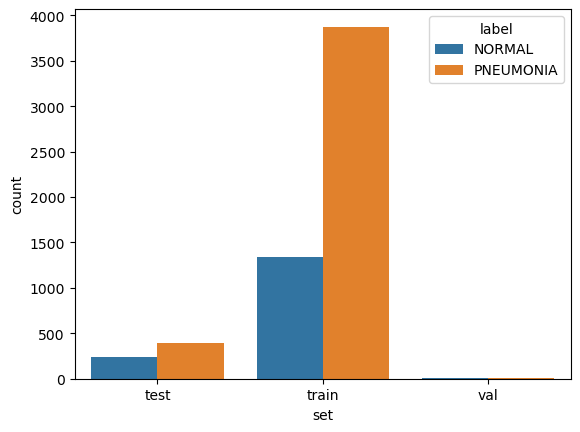

In [11]:
sns.countplot(data=df, x='set', hue='label');


### Reset train/test/val split, add more NORMAL data to dataset, balance the data and redo the train/test split

In [13]:
ds2_path = '../images/New-CNP-Dataset'


test_path_2 = 'testing'
train_path_2 = 'train'
val_path_2 = 'validation'

normal_path_2 = 'normal'
pneumonia_path_2 = 'pneumonia'

set_list_2 = [test_path_2, train_path_2, val_path_2]
label_list_2 = [normal_path_2, pneumonia_path_2]

set_list_2, label_list_2

(['testing', 'train', 'validation'], ['normal', 'pneumonia'])

In [14]:
img_dict_2 = {}

for s in set_list_2:
    for l in label_list_2:
        img_list_2 = os.listdir(f"{ds2_path}/{s}/{l}")
        for img in img_list_2:
            img_dict_2[f"{ds2_path}/{s}/{l}/{img}"] = [img, s, l]

In [15]:
df_2 = pd.DataFrame(data = img_dict_2).T.reset_index()
df_2.columns = ['path', 'filename', 'set', 'label']
df_2[['set', 'label']].value_counts()

set         label    
train       normal       1505
            pneumonia    1505
testing     normal        462
            pneumonia     462
validation  normal        346
            pneumonia     346
Name: count, dtype: int64

<Axes: xlabel='set', ylabel='count'>

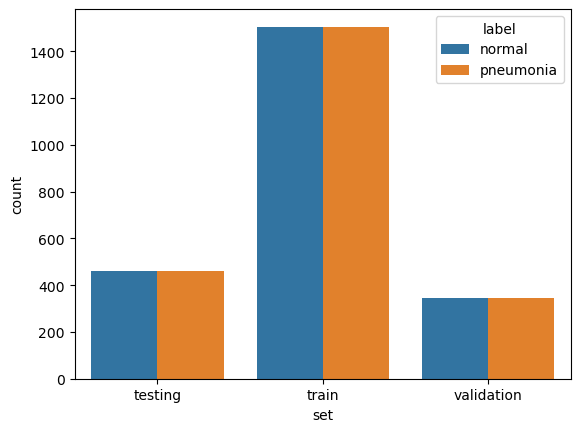

In [16]:
sns.countplot(data=df_2, x='set', hue='label')

### Combine dataframes

In [17]:
df_comb = pd.concat([df, df_2])
df_comb['set'] = 'set'
df_comb.loc[:, 'label'] = df_comb['label'].str.upper()
df_comb

,path,filename,set,label
0,../images/chest_xray/test/NORMAL/IM-0031-0001....,IM-0031-0001.jpeg,set,NORMAL
1,../images/chest_xray/test/NORMAL/IM-0025-0001....,IM-0025-0001.jpeg,set,NORMAL
2,../images/chest_xray/test/NORMAL/NORMAL2-IM-02...,NORMAL2-IM-0272-0001.jpeg,set,NORMAL
3,../images/chest_xray/test/NORMAL/NORMAL2-IM-01...,NORMAL2-IM-0102-0001.jpeg,set,NORMAL
4,../images/chest_xray/test/NORMAL/NORMAL2-IM-02...,NORMAL2-IM-0229-0001.jpeg,set,NORMAL
...,...,...,...,...
4621,../images/New-CNP-Dataset/validation/pneumonia...,person449_bacteria_1938.jpeg,set,PNEUMONIA
4622,../images/New-CNP-Dataset/validation/pneumonia...,person139_virus_283.jpeg,set,PNEUMONIA
4623,../images/New-CNP-Dataset/validation/pneumonia...,person1488_virus_2589.jpeg,set,PNEUMONIA
4624,../images/New-CNP-Dataset/validation/pneumonia...,person489_virus_994.jpeg,set,PNEUMONIA


<Axes: xlabel='set', ylabel='count'>

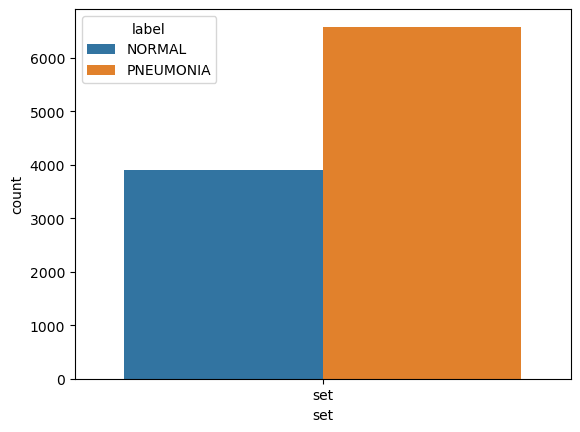

In [18]:
sns.countplot(data=df_comb, x='set', hue='label')

### Much more data to work with. Let's shuffle, drop excess PNEUMONIA and Train/Test split it.

In [19]:
df_normal = df_comb.loc[df_comb['label'] == 'NORMAL'].reset_index(drop=True)
n_normal = df_normal.shape[0]
n_normal

3896

In [20]:
df_pneumo = df_comb.loc[df_comb['label'] == 'PNEUMONIA']
df_pneumo.shape[0]

6586

In [21]:
df_pneumo = df_pneumo.sample(frac=1).reset_index(drop=True)
df_pneumo = df_pneumo.iloc[:n_normal].reset_index(drop=True)
df_pneumo.shape[0]

3896

In [22]:
# Get the number of images for 80/20 split
train_ratio = 0.8
test_ratio = 0.2
n_train, n_test = round(train_ratio * n_normal), round(test_ratio * n_normal)
f"{n_train = }, {n_test = }"

'n_train = 3117, n_test = 779'

In [23]:
df_normal.loc[:n_train, 'set'] = 'train'
df_normal.loc[n_train:, 'set'] = 'test'

df_pneumo.loc[:n_train, 'set'] = 'train'
df_pneumo.loc[n_train:, 'set'] = 'test'

df = pd.concat([df_normal, df_pneumo], ignore_index = True).reset_index(drop=True)

<Axes: xlabel='set', ylabel='count'>

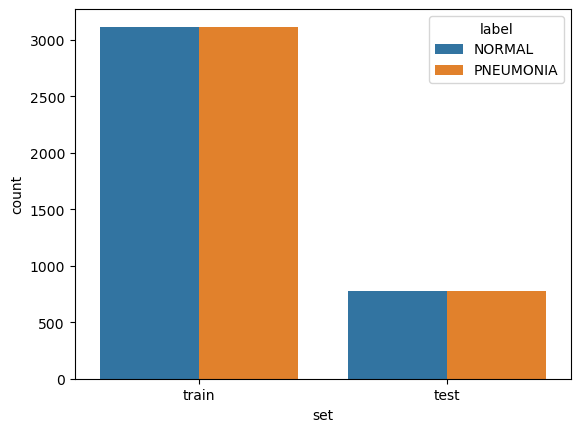

In [24]:
sns.countplot(data=df, x='set', hue='label')

In [25]:
df.head()

,path,filename,set,label
0,../images/chest_xray/test/NORMAL/IM-0031-0001....,IM-0031-0001.jpeg,train,NORMAL
1,../images/chest_xray/test/NORMAL/IM-0025-0001....,IM-0025-0001.jpeg,train,NORMAL
2,../images/chest_xray/test/NORMAL/NORMAL2-IM-02...,NORMAL2-IM-0272-0001.jpeg,train,NORMAL
3,../images/chest_xray/test/NORMAL/NORMAL2-IM-01...,NORMAL2-IM-0102-0001.jpeg,train,NORMAL
4,../images/chest_xray/test/NORMAL/NORMAL2-IM-02...,NORMAL2-IM-0229-0001.jpeg,train,NORMAL


# Visualization

In [26]:
image_height, image_width = 256, 256

In [27]:
# Function to load image into numpy array
def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [28]:
df.query('label == "PNEUMONIA" and set == "test"')[:6]

,path,filename,set,label
7013,../images/New-CNP-Dataset/train/pneumonia/pers...,person277_bacteria_1300.jpeg,test,PNEUMONIA
7014,../images/chest_xray/train/PNEUMONIA/person153...,person1532_virus_2667.jpeg,test,PNEUMONIA
7015,../images/New-CNP-Dataset/testing/pneumonia/pe...,person531_bacteria_2235.jpeg,test,PNEUMONIA
7016,../images/New-CNP-Dataset/train/pneumonia/pers...,person1328_virus_2295.jpeg,test,PNEUMONIA
7017,../images/New-CNP-Dataset/train/pneumonia/pers...,person1126_virus_1853.jpeg,test,PNEUMONIA
7018,../images/chest_xray/train/PNEUMONIA/person688...,person688_bacteria_2584.jpeg,test,PNEUMONIA


In [29]:
# Function to show 6 images from the set
def show_6_images(data, set, label):
    images = []
    d = data.query(f'label == "{label}" and set == "{set}"').reset_index(drop=True)[:6]
    for i, row in d.iterrows():
        img_path = row['path']
        image = Image.open(img_path).resize((image_height, image_width))
        images.append(load_image_into_numpy_array(image))
    

    for i, img in enumerate(images):
        plt.subplot(2, 3, i+1)
        plt.suptitle(f"{label} {set}")
        plt.imshow(images[i])
    plt.show()

In [30]:
set_list = ['train', 'test']
label_list = ['NORMAL', 'PNEUMONIA']
set_list, label_list

(['train', 'test'], ['NORMAL', 'PNEUMONIA'])

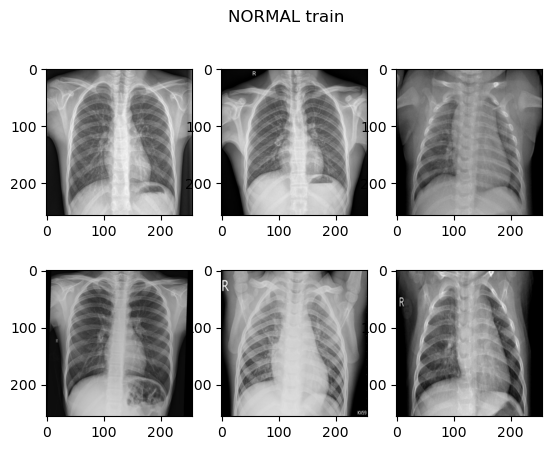

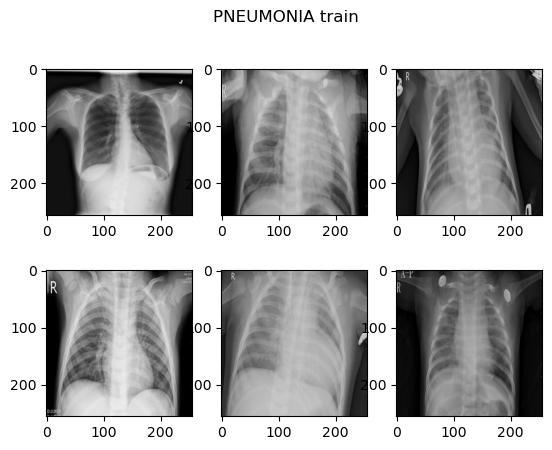

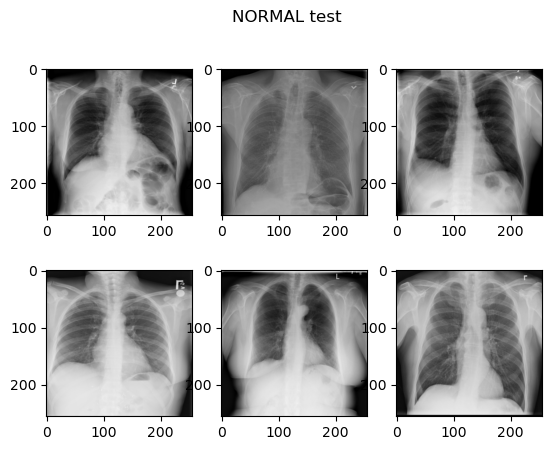

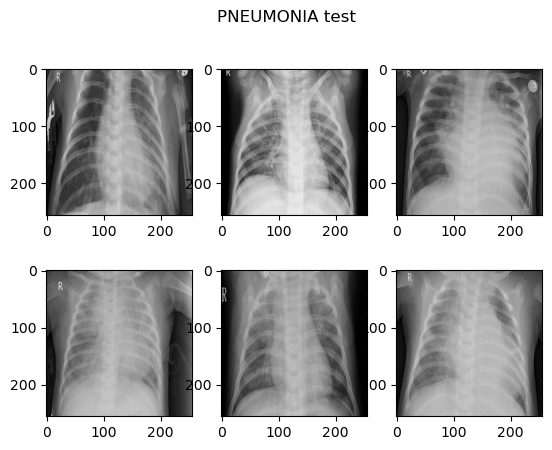

In [31]:
for s in set_list:
    for l in label_list:
        show_6_images(df, s, l)

# Copying images into folders

In [36]:
working_dir = '../images/working'

train_path = 'train'
test_path = 'test'
normal_path = 'NORMAL'
pneumo_path = 'PNEUMONIA'

In [37]:
set_list, label_list

(['train', 'test'], ['NORMAL', 'PNEUMONIA'])

In [34]:
# !rm -r /kaggle/working/test /kaggle/working/train

In [38]:
for s in set_list:
    for l in label_list:
        os.makedirs(f'{working_dir}/{s}/{l}', exist_ok=True)
        print(f"{working_dir}/{s}/{l} Created")

../images/working/train/NORMAL Created
../images/working/train/PNEUMONIA Created
../images/working/test/NORMAL Created
../images/working/test/PNEUMONIA Created


In [44]:
for s in set_list:
    for l in label_list:
        data = df.query(f'label == "{l}" and set == "{s}"')
        for i, row in data.iterrows():
            src = f"{row['path']}"
            dst = f'{working_dir}/{s}/{l}/{row["filename"]}'
            shutil.copy(src, dst)
        print(f'Done moving {s}/{l}')

Done moving train/NORMAL
Done moving train/PNEUMONIA
Done moving test/NORMAL
Done moving test/PNEUMONIA


# Training Model

In [45]:
# Load model if it exists
model_path = '../models/kaggle/working/export/Pneumonia_ROC_0975_cutoff_024.keras'
model = tf.keras.models.load_model(model_path)

In [37]:
pre_trained_model = InceptionV3(
    input_shape=(image_height, image_width, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output) # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x) # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x) # Add a dropout rate of 0.2
x = layers.Dense(1, activation='sigmoid')(x) # Add a final sigmoid layer for classification

model = Model(pre_trained_model.input, x) # Configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Done compiling the model!")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Done compiling the model!


In [46]:
# Data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [55]:
test_neg_dir = f"{working_dir}/{set_list[1]}/{label_list[0]}"
test_pos_dir = f"{working_dir}/{set_list[1]}/{label_list[1]}"
train_neg_dir = f"{working_dir}/{set_list[0]}/{label_list[0]}"
train_pos_dir = f"{working_dir}/{set_list[0]}/{label_list[1]}"
train_dir = f"{working_dir}/{train_path}"
test_dir = f"{working_dir}/{test_path}"
set_list, label_list, train_dir, test_dir, train_neg_dir, train_pos_dir, test_neg_dir, test_pos_dir

(['train', 'test'],
 ['NORMAL', 'PNEUMONIA'],
 '../images/working/train',
 '../images/working/test',
 '../images/working/train/NORMAL',
 '../images/working/train/PNEUMONIA',
 '../images/working/test/NORMAL',
 '../images/working/test/PNEUMONIA')

In [52]:
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(image_width, image_height),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(image_width, image_height),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(f"{working_dir}/{set_list[0]}/{label_list[1]}")) * 2
test_steps = len(os.listdir(f"{working_dir}/{set_list[1]}/{label_list[1]}")) * 2
print(f"{train_steps = } | {test_steps = }")
print("Done funneling data!")

Found 5535 images belonging to 2 classes.
Found 1524 images belonging to 2 classes.
train_steps = 5262 | test_steps = 1490
Done funneling data!


# Running the Model

In [44]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=20,
      validation_data=test_generator,
      validation_steps=test_steps,
#       verbose=2
)

Epoch 1/20
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 236s 43ms/step - accuracy: 0.8386 - loss: 0.6409 - val_accuracy: 0.8887 - val_loss: 0.3557
Epoch 2/20
 261/5268 ━━━━━━━━━━━━━━━━━━━━ 3:14 39ms/step - accuracy: 0.8831 - loss: 0.5105

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5268/5268 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8850 - loss: 0.4468 - val_accuracy: 0.6970 - val_loss: 0.9654
Epoch 3/20
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 224s 43ms/step - accuracy: 0.8933 - loss: 0.3151 - val_accuracy: 0.9256 - val_loss: 0.2287
Epoch 4/20
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9194 - loss: 0.1738 - val_accuracy: 0.8182 - val_loss: 0.2171
Epoch 5/20
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 227s 43ms/step - accuracy: 0.9021 - loss: 0.2980 - val_accuracy: 0.9491 - val_loss: 0.1634
Epoch 6/20
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8706 - loss: 0.3963 - val_accuracy: 0.9091 - val_loss: 0.3108
Epoch 7/20
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 227s 43ms/step - accuracy: 0.9168 - loss: 0.2688 - val_accuracy: 0.9390 - val_loss: 0.2118
Epoch 8/20
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9322 - loss: 0.2732 - val_accuracy: 0.6970 - val_loss: 0.9901
Epoch 9/20
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 227s 43ms/step - accuracy: 0.9166 - loss: 0.25

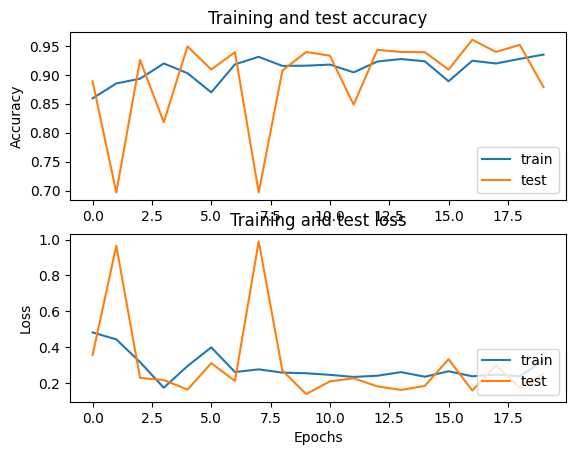

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()

# Evaluating Performance

In [53]:
def predict_image(filename):
  image = Image.open(filename).resize((image_width, image_height))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((image_width, image_height))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [56]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

I0000 00:00:1717742135.990420  956343 service.cc:145] XLA service 0x3123cb8c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717742135.990825  956343 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-06-06 23:35:36.067340: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1717742137.085103  956343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━

In [57]:
df.head()

,filepath,filename,label,guess,confidence
0,../images/working/test/PNEUMONIA/person1403_vi...,person1403_virus_2406.jpeg,pos,pos,1.0
1,../images/working/test/PNEUMONIA/person612_bac...,person612_bacteria_2477.jpeg,pos,pos,1.0
2,../images/working/test/PNEUMONIA/person458_bac...,person458_bacteria_1955.jpeg,pos,pos,1.0
3,../images/working/test/PNEUMONIA/person136_bac...,person136_bacteria_650.jpeg,pos,pos,1.0
4,../images/working/test/PNEUMONIA/person1028_ba...,person1028_bacteria_2960.jpeg,pos,pos,1.0


# Example Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


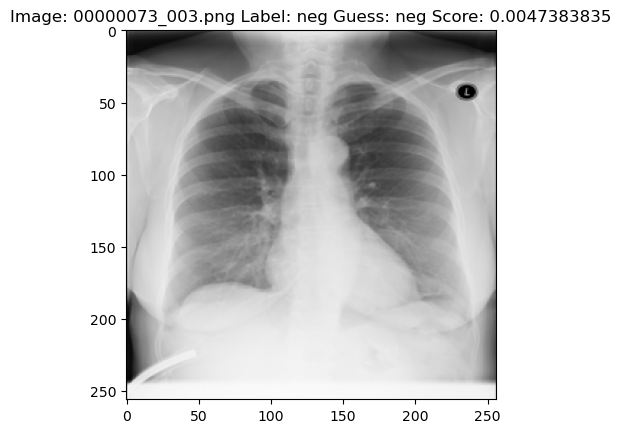

In [64]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

# Show Table if images

In [65]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,person1403_virus_2406.jpeg,pos,pos,1.000000
5,person563_bacteria_2333.jpeg,pos,pos,1.000000
10,person1180_virus_2015.jpeg,pos,pos,1.000000
15,person840_bacteria_2758.jpeg,pos,pos,1.000000
20,person1176_virus_1996.jpeg,pos,pos,1.000000
...,...,...,...,...
1500,NORMAL2-IM-1088-0001.jpeg,neg,neg,0.000190
1505,NORMAL2-IM-1187-0001.jpeg,neg,neg,0.000156
1510,00001318_004.png,neg,neg,0.000082
1515,00000795_000.png,neg,neg,0.000048


# Show Histogram

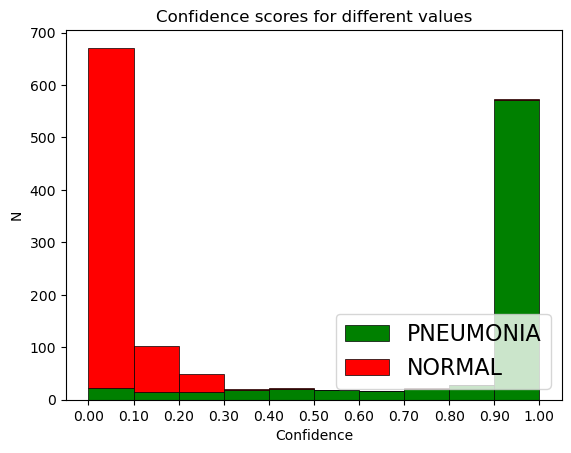

In [66]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=['PNEUMONIA', 'NORMAL'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

# Create Cutoff Point

In [71]:
cutoff = 0.24 #@param {type:"slider", min:0, max:1, step:0.01}

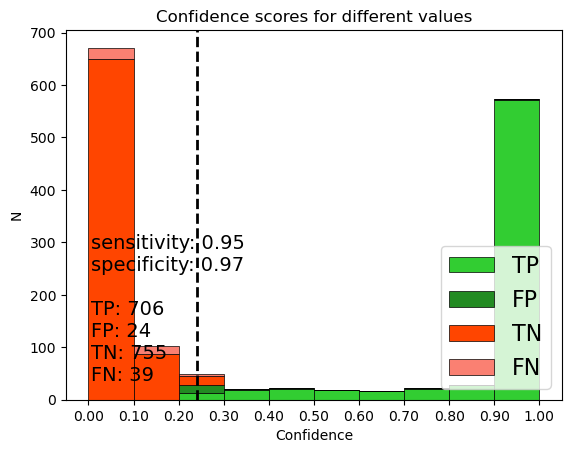

In [69]:
def create_with_cutoff(cutoff):
  __, ax = plt.subplots()
  TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
  FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
  FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
  TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]
  plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
          edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
          stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
          label=['TP','FP','TN','FN'])
  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.xticks(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for different values')
  plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc="lower right", fontsize=16)
  sens = round(len(TP)/(len(TP)+len(FN)),2)
  spec = round(len(TN)/(len(TN)+len(FP)),2)
  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff)

# Show ROC Curve

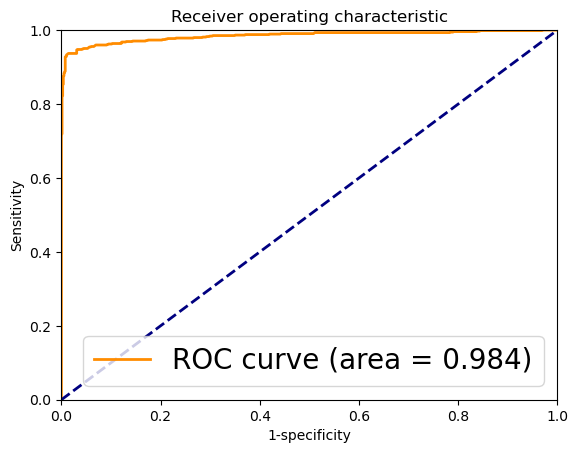

In [70]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]

  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()

In [179]:
# !mkdir export
# model.save(f'/kaggle/working/export/Pneumonia_ROC_0975_cutoff_024.keras')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [181]:
# !zip -r /kaggle/working/export/Pneumonia_ROC_0975_cutoff_024.zip /kaggle/working/export/Pneumonia_ROC_0975_cutoff_024.keras

  adding: kaggle/working/export/Pneumonia_ROC_0975_cutoff_024.keras (deflated 41%)
